# Hypothesis Testing with Insurance Data by Wesley Giles

## Import necessary modules and data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [3]:
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


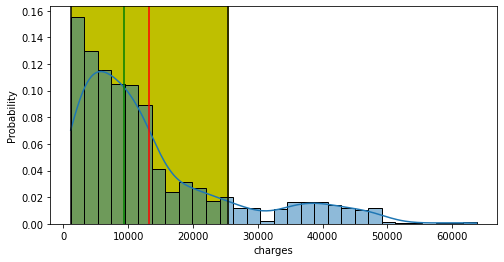

In [4]:
fig, ax = plt.subplots()
fig.set_figwidth(8)
sns.histplot(data=df, x="charges", stat='probability', ax=ax, kde=True)
mean = df["charges"].mean()
std = df["charges"].std()
ax.axvline(mean,c="r")
ax.axvline(df["charges"].median(),c="g")
ax.axvline(mean-std,c="k")
ax.axvline(mean+std,c="k")
ax.axvspan(mean-std,mean+std,color='y',zorder=0)

## Analysis

### Do smokers have higher insurance charges than non-smokers

#### State hypotheses

*H<sub>0</sub>*: There is no difference in insurance charges between smokers and non-smokers

*H<sub>1</sub>*: There is a significant decrease in insurance charges for non-smokers when compared to smokers

#### Determine which test to run in order to accept/reject the hypothesies

Independent t-tests seems to be the correct test to run as the data is numerical and has multiple samples

#### Test assumptions

We need to remove significant outliers from the data, so let's visualize thes outliers first

<AxesSubplot:xlabel='smoker', ylabel='charges'>

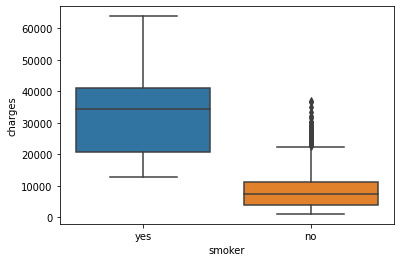

In [5]:
sns.boxplot(data= df,x = "smoker", y="charges")

Smokers seem to have no significant outliers, however non-smokers have several. let's drop these values

In [6]:
cutoff = scipy.stats.iqr(df[df["smoker"] == "no"]["charges"]) * 1.5
cutoff += np.quantile(df[df["smoker"] == "no"]["charges"], 0.75)
cutoff

22427.559575

In [7]:
outlier_filter = (df["smoker"] == "no") & (df["charges"] > cutoff)
outlier_filter.sum()

46

<AxesSubplot:xlabel='smoker', ylabel='charges'>

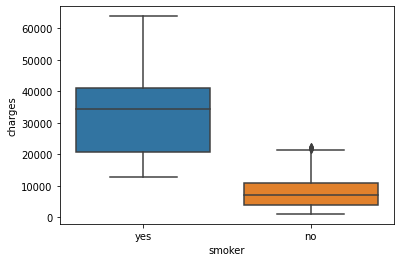

In [8]:
df.drop(df[outlier_filter].index, inplace= True)
sns.boxplot(data= df,x = "smoker", y="charges")

Now that the majority of outliers have been removed we can test if these sets are normal

In [9]:
for val in ["yes","no"]:
  print(f"smoker? {val}: {scipy.stats.normaltest(df[df['smoker'] == val]['charges'])}")

smoker? yes: NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)
smoker? no: NormaltestResult(statistic=60.528203444171986, pvalue=7.185675855038122e-14)


Neither group is normalized, but there may be enough samples to ignore this.

In [10]:
for val in ["yes","no"]:
  print(f"count for {val}: {df[df['smoker'] == val]['charges'].count()}")

count for yes: 274
count for no: 1018


Lets also visualize the distributions of this data 

<AxesSubplot:xlabel='charges', ylabel='Probability'>

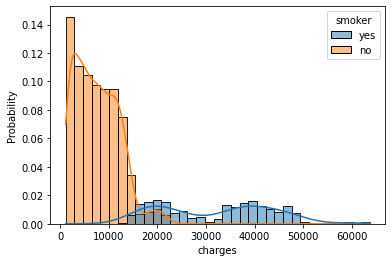

In [11]:
sns.histplot(data=df, x="charges",hue="smoker",stat='probability', kde=True)
# mean = df["charges"].mean()
# std = df["charges"].std()
# ax.axvline(mean,c="r")
# ax.axvline(df["charges"].median(),c="g")

Finally let's do a levene's test to check for equal variance

In [12]:
scipy.stats.levene(df[df["smoker"] == "no"]["charges"], df[df["smoker"] == "yes"]["charges"])

LeveneResult(statistic=696.1069060709332, pvalue=4.92352245333529e-123)

Well the p value tells us we reject Levene's null hypothesis and our data groups have differing varience, which will have to be accounted for in the t-test

#### Run Test

In [13]:
scipy.stats.ttest_ind(df[df["smoker"] == "no"]["charges"], df[df["smoker"] == "yes"]["charges"], equal_var=False)

Ttest_indResult(statistic=-34.40728287175559, pvalue=2.3481497960765525e-105)

With this very low p-score we reject the null hypothesis, and can accept the alternate hypothesis, that there is a significant decrease in insurance charges for non-smokers when compared to smokers

<AxesSubplot:xlabel='smoker', ylabel='charges'>

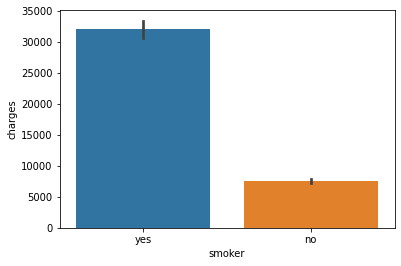

In [14]:
sns.barplot(data=df, x="smoker",y="charges")

### Are men more likely to smoke than women?

#### State hypotheses
*H<sub>0</sub>*: There is no difference in amount of smokers between men and women.

*H<sub>1</sub>*: There is a significant difference in amount of smokers between men and women


#### Determine which test to run in order to accept/reject the hypothesies



Chi-squared seems to be the appropiate test considering our check for membership across categories

#### Test assumptions


There are two categorical variables

In [15]:
print(df["sex"].unique())
print(df["smoker"].unique())

['female' 'male']
['yes' 'no']


These look pretty categorical to me

The outcomes are independent.

While we are testing for correlation sex is not a causation of smoking, and likewise smoking is not a causation of ones sex, so this assuption is met.

#### Run Test

First let's visualize the data

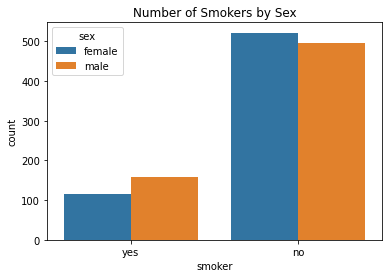

In [17]:
ax = sns.countplot(data=df, x='smoker',hue='sex',)
ax.set_title("Number of Smokers by Sex");

While it looks like males are more inclined to smoke, let's prove it eith statistics

In [18]:
cross_tab = pd.crosstab(df["sex"],df["smoker"])
cross_tab

smoker,no,yes
sex,,
female,522,115
male,496,159


In [20]:
results = scipy.stats.chi2_contingency(cross_tab)
chi2, p, deg_free, expected_vals = results

In [21]:
print(f"{p} < 0.05? : {p<0.05}")

0.007653843147742742 < 0.05? : True


The p_score is less than the alpha of 0.05, so we can rejext the null hypothesis and support the alternate hypothesis that 'There is a significant difference in amount of smokers between men and women'

We can explore this further to see the expected vs the actual and determine which direction the data leans towards

In [22]:
cross_tab - expected_vals

smoker,no,yes
sex,,
female,20.091331,-20.091331
male,-20.091331,20.091331


Using this data we can tell that men smoke more often than women in this data set.

### Do different regions have different charges, on average?

#### State hypotheses
*H<sub>0</sub>*: There is no difference in average insurance charges between regions.

*H<sub>1</sub>*: There is a significant difference in average insurance charges between regions.
